In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import des librairies

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from imblearn.metrics import classification_report_imbalanced

In [29]:
# Import DataFrame pour modélisation
df = pd.read_csv('/content/df_model.csv', index_col=0)

# La saison lue en tant que numérique est remise en chaine de caractère
df['Saison'] = df['Saison'].astype(str)
df_tot=df.copy()

# Sélection des variables

Après maints essais de sélection de variables avec différentes méthodes (SelectKBest, PCA, ...), qui ont donné des scores moins élevés, nous avons tenté plusieurs sélections manuelles en privilégiant les variables avec les coefficients de corrélation les plus élevés (+ ou -) avec le résultat du match.

Voici celle qui a donné les meilleurs résultats :

In [30]:
# Variables sélectionnées pour la modélisation
xvars = ['Saison','Min_cote_domicile','Min_cote_exterieur','note_def_ext','note_gen_dom','Points_moy_match_saison_dom','Moy_buts_5_matchs_dom',
           'Points_moy_match_saison_ext']

df = df.loc[:, xvars + ["Resultat_match"]]
df['Resultat_match'] = df['Resultat_match'].replace(['H','D','A'], [2, 1,0])

In [31]:
# Création des dataframes de cible et de données
target = df[['Resultat_match','Saison']]
data = df.loc[:, xvars]

# Remplacement des modalités de target par des nombres pour la modélisation
target['Resultat_match'] = target['Resultat_match'].replace(['H','D','A'], [2, 1,0])

# Création des dataframe d'entrainenemnt et de test : entrainement sur les saison 2015 à 2020 et test sur 2021 (saison non encore terminée)
X_train_=data.loc[data['Saison'] != '2021', :].drop('Saison',axis=1)
X_test_=data.loc[data['Saison'] == '2021', :].drop('Saison',axis=1)
y_train=target.loc[target['Saison'] != '2021', :].drop('Saison',axis=1)
y_test=target.loc[target['Saison'] == '2021', :].drop('Saison',axis=1)
print(X_train_.shape)
print(X_test_.shape)
print(y_train.shape)
print(y_test.shape)

# Standardisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_)
X_test = scaler.transform(X_test_)

y_test=y_test.to_numpy().reshape(220,)
y_train=y_train.to_numpy().reshape(2178,)

(2178, 7)
(220, 7)
(2178, 1)
(220, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Modèle le plus performant

Nous allons montrer ici que le modèle KNN (avec ses meilleurs paramètres) est le modèle le plus performant pour les prédictions de résultats de matchs

In [14]:
# Modèle SVM
svm = svm.SVC()
parametres_svm = {'C':[0.1,1,2,5], 
                  'kernel':['rbf','linear', 'poly'], 
                  'gamma':[0.001, 0.1,0.2, 0.5]}

grid_svm = GridSearchCV(estimator = svm, param_grid = parametres_svm)

# Modèle KNN
knn = KNeighborsClassifier()
parametres_knn = {'n_neighbors' : [k for k in range(10,60,5)],
                  'weights' : ['uniform', 'distance'],
                 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                 'metric' : ['minkowski', 'manhattan', 'chebyshev', 'euclidean']}

grid_knn = GridSearchCV(estimator = knn, param_grid = parametres_knn)

# Modèle RF
rf = RandomForestClassifier()
parametres_rf = {'max_features': ["sqrt", "log2"], 
                 'min_samples_split': range(20, 50, 2)}

grid_rf = GridSearchCV(estimator=rf, param_grid = parametres_rf, cv=4)

# Validation croisée
cv = KFold(n_splits=3, random_state=22 , shuffle = True)

for clf, label in zip([grid_svm, grid_knn, grid_rf], ['SVM','KNN', 'Random Forest']):
    scores = cross_validate(clf, X_train, y_train, cv=cv, scoring=['accuracy','f1_micro', 'f1_macro', 'f1_weighted'])
    clf.fit(X_train, y_train)
    print('Meilleurs paramètres :', clf.best_params_)

    print("[%s]: \n Accuracy: %0.2f (+/- %0.2f)" % (label, scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
          "F1 micro score: %0.2f (+/- %0.2f)" % (scores['test_f1_micro'].mean(), scores['test_f1_micro'].std()),
          "F1 macro score: %0.2f (+/- %0.2f)" % (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std()),
          "F1 weighted score: %0.2f (+/- %0.2f)" % (scores['test_f1_weighted'].mean(), scores['test_f1_weighted'].std()),)

Meilleurs paramètres : {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
[SVM]: 
 Accuracy: 0.52 (+/- 0.02) F1 micro score: 0.52 (+/- 0.02) F1 macro score: 0.38 (+/- 0.01) F1 weighted score: 0.43 (+/- 0.01)
Meilleurs paramètres : {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 55, 'weights': 'uniform'}
[KNN]: 
 Accuracy: 0.52 (+/- 0.02) F1 micro score: 0.52 (+/- 0.02) F1 macro score: 0.45 (+/- 0.02) F1 weighted score: 0.48 (+/- 0.02)
Meilleurs paramètres : {'max_features': 'log2', 'min_samples_split': 40}
[Random Forest]: 
 Accuracy: 0.52 (+/- 0.01) F1 micro score: 0.52 (+/- 0.01) F1 macro score: 0.44 (+/- 0.01) F1 weighted score: 0.48 (+/- 0.01)


Accuracy:  0.4772727272727273
                   pre       rec       spe        f1       geo       iba       sup

          0       0.49      0.44      0.81      0.46      0.59      0.34        66
          1       0.00      0.00      0.99      0.00      0.00      0.00        63
          2       0.47      0.84      0.35      0.61      0.54      0.31        91

avg / total       0.34      0.48      0.67      0.39      0.40      0.23       220



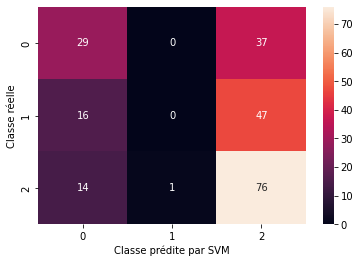

In [15]:
# Matrice de confusion et score pour SVM
y_pred_svm = grid_svm.predict(X_test)
confusion_matrix=pd.crosstab(y_test, y_pred_svm, rownames = ['Classe réelle'], colnames = ['Classe prédite par SVM'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_svm));

# Rapport de classification
print(classification_report_imbalanced(y_test, y_pred_svm)) 

Accuracy:  0.5181818181818182
                   pre       rec       spe        f1       geo       iba       sup

          0       0.49      0.41      0.82      0.45      0.58      0.32        66
          1       0.48      0.21      0.91      0.29      0.43      0.17        63
          2       0.54      0.81      0.50      0.65      0.64      0.42        91

avg / total       0.51      0.52      0.71      0.48      0.56      0.32       220



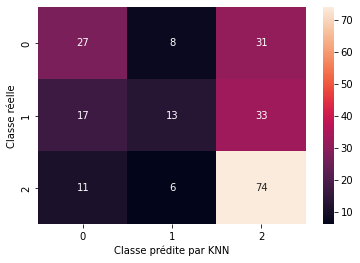

In [16]:
# Matrice de confusion et score pour KNN
y_pred_knn = grid_knn.predict(X_test)
confusion_matrix=pd.crosstab(y_test, y_pred_knn, rownames = ['Classe réelle'], colnames = ['Classe prédite par KNN'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_knn));

# Rapport de classification
print(classification_report_imbalanced(y_test, y_pred_knn)) 

Accuracy:  0.4863636363636364
                   pre       rec       spe        f1       geo       iba       sup

          0       0.46      0.47      0.77      0.47      0.60      0.35        66
          1       0.45      0.14      0.93      0.22      0.36      0.12        63
          2       0.50      0.74      0.49      0.60      0.60      0.37        91

avg / total       0.48      0.49      0.70      0.45      0.53      0.29       220



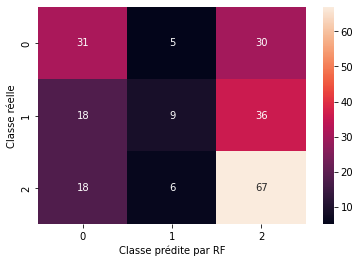

In [17]:
# Matrice de confusion et score pour RF
y_pred_rf = grid_rf.predict(X_test)
confusion_matrix=pd.crosstab(y_test, y_pred_rf, rownames = ['Classe réelle'], colnames = ['Classe prédite par RF'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_rf));

# Rapport de classification
print(classification_report_imbalanced(y_test, y_pred_rf)) 

# Voting Classifier

On utilise un méta-classifieur, pour voir si on peut tirer profit des trois modèles précédents.

In [20]:
from sklearn import svm
# On recrée les trois modèles précédents, avec leurs meilleurs paramètres
svm  = svm.SVC(C = 1, gamma = 0.1, kernel ='rbf')
rf = RandomForestClassifier(max_features ='sqrt', min_samples_split = 46)
knn = KNeighborsClassifier(algorithm ='auto', metric ='minkowski', n_neighbors = 55, weights= 'uniform')


vclf = VotingClassifier(estimators=[('knn', knn), ('rf', rf), ('svm', svm)], voting='hard')
cv2 = KFold(n_splits=3, random_state=111 , shuffle = True)

for clf, label in zip([knn, rf, svm, vclf], ['KNN', 'Random Forest', 'SVM', 'Voting Classifier']):
    scores = cross_validate(clf, X_train, y_train, cv = cv2, scoring = ['accuracy','f1_micro', 'f1_macro', 'f1_weighted'])
    print("[%s]: \n Accuracy: %0.2f (+/- %0.2f)" % (label, scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
          "F1 micro score: %0.2f (+/- %0.2f)" % (scores['test_f1_micro'].mean(), scores['test_f1_micro'].std()),
          "F1 macro score: %0.2f (+/- %0.2f)" % (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std()),
          "F1 weighted score: %0.2f (+/- %0.2f)" % (scores['test_f1_weighted'].mean(), scores['test_f1_weighted'].std()),)


[KNN]: 
 Accuracy: 0.50 (+/- 0.01) F1 micro score: 0.50 (+/- 0.01) F1 macro score: 0.43 (+/- 0.02) F1 weighted score: 0.47 (+/- 0.02)
[Random Forest]: 
 Accuracy: 0.52 (+/- 0.02) F1 micro score: 0.52 (+/- 0.02) F1 macro score: 0.43 (+/- 0.01) F1 weighted score: 0.47 (+/- 0.02)
[SVM]: 
 Accuracy: 0.51 (+/- 0.02) F1 micro score: 0.51 (+/- 0.02) F1 macro score: 0.37 (+/- 0.02) F1 weighted score: 0.43 (+/- 0.03)
[Voting Classifier]: 
 Accuracy: 0.51 (+/- 0.02) F1 micro score: 0.51 (+/- 0.02) F1 macro score: 0.40 (+/- 0.02) F1 weighted score: 0.45 (+/- 0.02)


Accuracy:  0.4909090909090909
                   pre       rec       spe        f1       geo       iba       sup

          0       0.48      0.45      0.79      0.47      0.60      0.35        66
          1       0.50      0.05      0.98      0.09      0.22      0.04        63
          2       0.49      0.82      0.40      0.62      0.58      0.35        91

avg / total       0.49      0.49      0.69      0.42      0.48      0.26       220



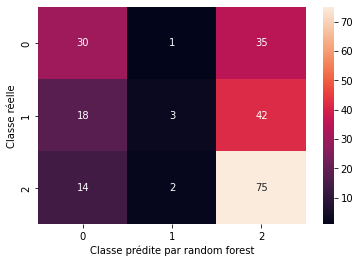

In [21]:
# Matrice de confusion et score
vclf.fit(X_train, y_train)
y_pred_vclf = vclf.predict(X_test)
confusion_matrix=pd.crosstab(y_test, y_pred_vclf, rownames = ['Classe réelle'], colnames = ['Classe prédite par random forest'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_vclf));

# Rapport de classification
print(classification_report_imbalanced(y_test, y_pred_vclf)) 

Le score reste moins bon qu'avec KNN

# Gain avec le meilleur modèle (KNN)

Accuracy:  0.5181818181818182
                   pre       rec       spe        f1       geo       iba       sup

          0       0.49      0.41      0.82      0.45      0.58      0.32        66
          1       0.48      0.21      0.91      0.29      0.43      0.17        63
          2       0.54      0.81      0.50      0.65      0.64      0.42        91

avg / total       0.51      0.52      0.71      0.48      0.56      0.32       220



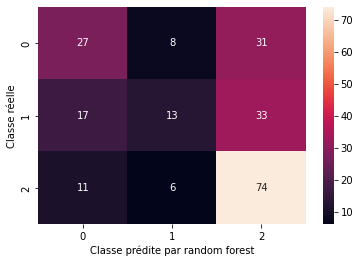

In [23]:
# On reprend notre modèle KNN
knn = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors= 55, weights= 'uniform')
cv = KFold(n_splits=3, random_state=22 , shuffle = True)

scores = cross_validate(knn, X_train, y_train, cv=cv, scoring=['accuracy','f1_micro', 'f1_macro', 'f1_weighted'])
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
confusion_matrix=pd.crosstab(y_test, y_pred_knn, rownames = ['Classe réelle'], colnames = ['Classe prédite par random forest'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_knn));
print(classification_report_imbalanced(y_test, y_pred_knn)) 

Accuracy:  0.5371900826446281


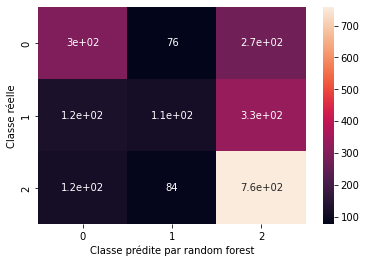

In [24]:
# On prend aussi les prédictions sur le jeu d'entraînement
y_pred_knn_train = knn.predict(X_train)
confusion_matrix=pd.crosstab(y_train, y_pred_knn_train, rownames = ['Classe réelle'], colnames = ['Classe prédite par random forest'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_train, y_pred_knn_train));

In [52]:
# On récupère nos prédictions dans un dataframe
y_pred_knn_df= pd.DataFrame(y_pred_knn)
y_pred_knn_train_df = pd.DataFrame(y_pred_knn_train)

y = pd.concat([y_pred_knn_train_df, y_pred_knn_df])
y.columns = ['Prediction']
y.reset_index(inplace=True,drop=True)

Préparation des données pour le calcul des gains

In [53]:
# On récupère nos données de départ
df_complet = df_tot.copy()
df_complet['Resultat_match'] = df_complet['Resultat_match'].replace(['H','D','A'], [2, 1,0])
df_complet.reset_index(inplace=True,drop=True)
# Ajout des prédictions faites à partir du meilleur KNN
df_avec_pred = pd.concat([df_complet, y],axis=1)
df_avec_pred.head(3)

,Saison,Resultat_match,Moy_cote_domicile,Max_cote_domicile,Min_cote_domicile,Moy_cote_exterieur,Max_cote_exterieur,Min_cote_exterieur,Moy_cote_nul,Max_cote_nul,Min_cote_nul,Nb_buts_equipe_dom_an_dernier,Nb_buts_equipe_ext_an_dernier,Num_match_dom,Moy_points_5_match_dom,Moy_buts_5_matchs_dom,Moy_tirs_cadres_5_matchs_dom,Moy_tirs_5_matchs_dom,Nb_jours_dernier_match_dom,Moy_nb_fautes_5_matchs_dom,Moy_corners_5_matchs_dom,Moy_carton_J_5_matchs_dom,Moy_carton_R_5_matchs_dom,Num_match_ext,Moy_points_5_match_ext,Moy_buts_5_matchs_ext,Moy_tirs_cadres_5_matchs_ext,Moy_tirs_5_matchs_ext,Nb_jours_dernier_match_ext,Moy_nb_fautes_5_matchs_ext,Moy_corners_5_matchs_ext,Moy_carton_J_5_matchs_ext,Moy_carton_R_5_matchs_ext,Points_moy_match_saison_dom,Points_moy_match_saison_ext,Pct_buts_par_tirs_cadres_5m_dom,Pct_buts_par_tirs_cadres_5m_ext,note_att_dom,note_mil_dom,note_def_dom,note_gen_dom,note_att_ext,note_mil_ext,note_def_ext,note_gen_ext,Res_an_dernier_A,Res_an_dernier_D,Res_an_dernier_H,Prediction
0,2015,0,6.22,7.00,4.65,1.65,1.75,1.57,3.63,3.8,3.40,0.0,0.0,1,1.0,1.29075,4.122589,11.9191,8,13.019501,4.765234,0.0,0.0,1,1.0,1.322451,4.190211,12.128774,8,12.97336,4.873537,0.0,0.0,1.0,1.0,0.313092,0.315605,75,73,76,75,84,82,82,83,0,0,0,0
1,2015,2,2.56,2.71,2.30,2.97,3.10,2.80,3.01,3.1,2.88,0.0,0.0,1,1.0,1.29075,4.122589,11.9191,8,13.019501,4.765234,0.0,0.0,1,1.0,1.322451,4.190211,12.128774,8,12.97336,4.873537,0.0,0.0,1.0,1.0,0.313092,0.315605,70,71,71,71,76,75,75,75,0,0,0,2
2,2015,0,1.55,1.57,1.50,6.05,6.59,5.50,4.08,4.4,3.70,0.0,0.0,1,1.0,1.29075,4.122589,11.9191,8,13.019501,4.765234,0.0,0.0,1,1.0,1.322451,4.190211,12.128774,8,12.97336,4.873537,0.0,0.0,1.0,1.0,0.313092,0.315605,77,76,74,76,71,71,72,71,0,0,0,2


In [42]:
# Recherche du résultat le plus probable
df_avec_pred['Cote_result_plus_probable']=df_avec_pred[['Max_cote_domicile','Max_cote_exterieur','Max_cote_nul']].min(axis=1)

# Récupération de la modalité la plus probable selon les bookmakers
df_avec_pred.loc[df_avec_pred['Cote_result_plus_probable'] == df_avec_pred['Max_cote_domicile'], 'Result_plus_probable'] = 'H'
df_avec_pred.loc[df_avec_pred['Cote_result_plus_probable'] == df_avec_pred['Max_cote_exterieur'], 'Result_plus_probable'] = 'A' 
df_avec_pred.loc[df_avec_pred['Cote_result_plus_probable'] == df_avec_pred['Max_cote_nul'], 'Result_plus_probable'] = 'D'

# Recherche de la cote du bon résultat
df_avec_pred.loc[df_avec_pred['Resultat_match'] == 0, 'Cote_max_result'] = df_avec_pred['Max_cote_exterieur']
df_avec_pred.loc[df_avec_pred['Resultat_match'] == 1, 'Cote_max_result'] = df_avec_pred['Max_cote_nul']
df_avec_pred.loc[df_avec_pred['Resultat_match'] == 2, 'Cote_max_result'] = df_avec_pred['Max_cote_domicile']

# Mise de départ
df_avec_pred[['gain_perte']] = -10

# Si bon pari, gain
df_avec_pred.loc[df_avec_pred['Resultat_match'] == df_avec_pred['Prediction'], 'gain_perte'] = 10 * df_avec_pred['Cote_max_result'] - 10

# Calcul des cumuls des montants
df_avec_pred['gain_perte_tot'] = df_avec_pred.groupby(['Saison'])['gain_perte'].cumsum()+1000

# Numéro du match de la saison
df_avec_pred['x']=1
df_avec_pred['x'] = df_avec_pred.groupby(['Saison'])['x'].cumsum()

# Pour affichage par saison
df_avec_pred.set_index(['x'], inplace=True)


Plot des gains par saison en suivant les prévisions du meilleur modèle avec une enveloppe de départ de 1000 € et une mise de 10 € par match

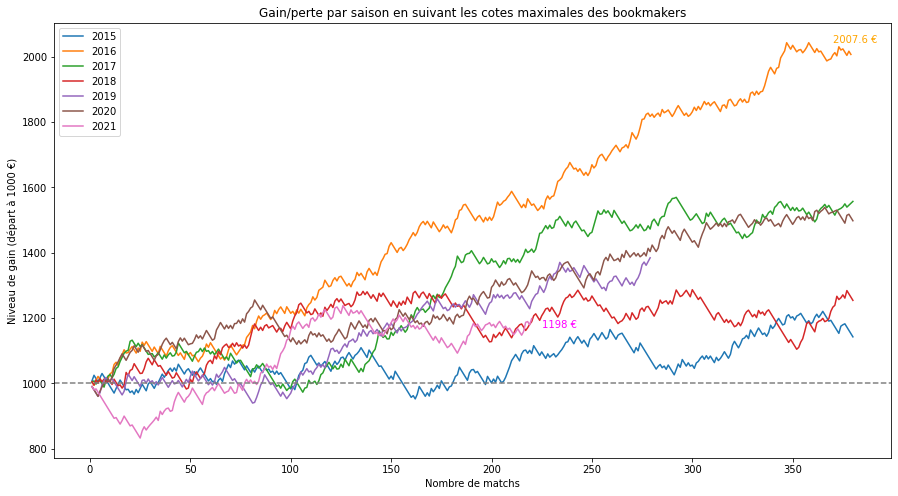

In [49]:
ax=plt.figure(figsize = (15, 8))
df_avec_pred.groupby('Saison')['gain_perte_tot'].plot(legend=True)
plt.title('Gain/perte par saison en suivant les cotes maximales des bookmakers')
plt.xlabel("Nombre de matchs")
plt.ylabel("Niveau de gain (départ à 1000 €)")
plt.axhline(y=1000,color='gray',linestyle='--')

# Affichage de 2 montants finaux
plt.text(370, 2045, '2007.6 €', color='orange')
plt.text(225, 1170, '1198 €', color='fuchsia');